# Нейронные сети в медицине

## 1. Подготовка данных и окружения

In [21]:
# Импортируем базовые библиотеки
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Импортируем инструменты Keras для работы с изображениями и создания модели
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**Выведем изображения**

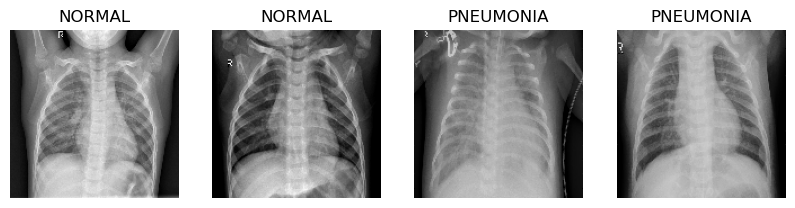

In [25]:
# Задаем путь к датасету (укажите свой путь, если он отличается)
base_dir = 'chest_xray/train'

# Пути к папкам с изображениями
normal_dir = os.path.join(base_dir, 'NORMAL')
pneumonia_dir = os.path.join(base_dir, 'PNEUMONIA')

# Получаем список файлов
normal_files = os.listdir(normal_dir)[:2]      # берем первые 2 изображения
pneumonia_files = os.listdir(pneumonia_dir)[:2]  # берем первые 2 изображения

# Функция для загрузки и нормализации изображения
def load_and_preprocess_image(filepath, target_size=(150, 150)):
    # Загружаем изображение, меняем размер до target_size
    img = load_img(filepath, target_size=target_size)
    # Преобразуем в массив
    img_array = img_to_array(img)
    # Нормализуем пиксели
    img_array /= 255.0
    return img_array

# Загружаем изображения
images = []
titles = []

for fname in normal_files:
    img_path = os.path.join(normal_dir, fname)
    img = load_and_preprocess_image(img_path)
    images.append(img)
    titles.append('NORMAL')

for fname in pneumonia_files:
    img_path = os.path.join(pneumonia_dir, fname)
    img = load_and_preprocess_image(img_path)
    images.append(img)
    titles.append('PNEUMONIA')

# Выводим изображения
plt.figure(figsize=(10, 5))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.show()


## 2. Создание и обучение нейронной сети

Подготовка генераторов данных
Для удобной загрузки и нормализации изображений воспользуемся ImageDataGenerator. Это также позволит нам в дальнейшем легко добавить аугментацию.

In [35]:
# Задаем пути к обучающему и тестовому набору
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

# Создаем генератор для обучающей выборки (без аугментации на данном этапе)
train_datagen = ImageDataGenerator(
    rescale=1./255,      # нормализация пикселей
    validation_split=0.2 # можно выделить часть обучающего набора для валидации
)

# Генератор для тестовой выборки
test_datagen = ImageDataGenerator(rescale=1./255)

# Параметры генератора
img_height, img_width = 150, 150
batch_size = 32

# Создаем генераторы
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'  # 80% для обучения
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'  # 20% для валидации
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # для корректной оценки
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Создание архитектуры сверточной нейронной сети**

In [43]:
# Определяем архитектуру CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # для борьбы с переобучением
    Dense(1, activation='sigmoid')  # бинарная классификация
])

# Компилируем модель
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Выводим архитектуру модели
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

**Обучение модели**

In [45]:
# Для контроля переобучения можно использовать EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Обучаем модель
epochs = 15

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stop]
)

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 63s 474ms/step - accuracy: 0.7327 - loss: 0.5513 - val_accuracy: 0.9131 - val_loss: 0.2308
Epoch 2/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.9375 - loss: 0.1966

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.9375 - loss: 0.1966 - val_accuracy: 0.9141 - val_loss: 0.2301
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.9051 - loss: 0.2258 - val_accuracy: 0.9482 - val_loss: 0.1389
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9688 - loss: 0.0621 - val_accuracy: 0.9424 - val_loss: 0.1488
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 285ms/step - accuracy: 0.9456 - loss: 0.1566 - val_accuracy: 0.9570 - val_loss: 0.1167
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9688 - loss: 0.0915 - val_accuracy: 0.9590 - val_loss: 0.1156
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 296ms/step - accuracy: 0.9538 - loss: 0.1194 - val_accuracy: 0.9580 - val_loss: 0.1173
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9688 - loss: 0.1345 - val_accuracy: 0.9590 - val_loss: 0.1173
Epoch 9/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 38s 289ms/step - accuracy: 0.9579 - loss: 0.1192 - val_accurac

## 3. Оценка качества модели

Тестирование модели на независимой выборке

In [47]:
# Оцениваем модель на тестовой выборке
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.6121 - loss: 1.5358
Test Loss: 0.9131
Test Accuracy: 0.7763


Вычисление precision и recall
Для более детальной оценки можно получить предсказания и вычислить precision и recall с помощью библиотеки scikit-learn.

In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# Получаем предсказания (вероятности) для тестовой выборки
test_generator.reset()
pred_probabilities = model.predict(test_generator, steps=test_generator.samples // batch_size, verbose=1)
predictions = (pred_probabilities > 0.5).astype(int).flatten()

# Истинные метки
true_labels = test_generator.classes[:len(predictions)]

# Выводим отчёт по метрикам
print(classification_report(true_labels, predictions, target_names=['NORMAL', 'PNEUMONIA']))

# Выводим матрицу ошибок
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step
              precision    recall  f1-score   support

      NORMAL       0.95      0.44      0.60       234
   PNEUMONIA       0.74      0.98      0.84       374

    accuracy                           0.78       608
   macro avg       0.84      0.71      0.72       608
weighted avg       0.82      0.78      0.75       608

Confusion Matrix:
[[104 130]
 [  6 368]]


**Выводы**

После обучения и оценки модели:

 точность (accuracy) тестовой выборки  70–80%, можно считать задачу решённой.
Аугментация данных часто помогает улучшить обобщающую способность модели за счёт искусственного увеличения объема обучающих данных.
Можно экспериментировать с количеством слоев, фильтров, параметрами аугментации, learning rate и другими гиперпараметрами для дальнейшего улучшения результатов.


# 4.Аугментация данных

Для увеличения объема данных и улучшения результатов можно применить аугментацию. Добавим в генератор аугментацию: горизонтальное отражение, поворот и зум.

In [55]:
# Создаем генератор с аугментацией
augmented_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # поворот до 20 градусов
    width_shift_range=0.1,   # сдвиг по ширине
    height_shift_range=0.1,  # сдвиг по высоте
    shear_range=0.1,
    zoom_range=0.2,          # приближение/отдаление
    horizontal_flip=True,    # горизонтальное отражение
    fill_mode='nearest',
    validation_split=0.2     # аналогично предыдущему генератору
)

augmented_train_generator = augmented_train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

augmented_validation_generator = augmented_train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Создаем ту же архитектуру модели (можно использовать ту же, что и ранее)
model_aug = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_aug.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Обучаем модель с аугментацией
history_aug = model_aug.fit(
    augmented_train_generator,
    steps_per_epoch=augmented_train_generator.samples // batch_size,
    validation_data=augmented_validation_generator,
    validation_steps=augmented_validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=[early_stop]
)

# Оцениваем модель с аугментацией на тестовой выборке
test_loss_aug, test_acc_aug = model_aug.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"After Augmentation - Test Loss: {test_loss_aug:.4f}")
print(f"After Augmentation - Test Accuracy: {test_acc_aug:.4f}")


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 50s 377ms/step - accuracy: 0.7494 - loss: 0.5782 - val_accuracy: 0.8369 - val_loss: 0.3923
Epoch 2/15
  1/130 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.9062 - loss: 0.3827

C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9062 - loss: 0.3827 - val_accuracy: 0.8066 - val_loss: 0.3809
Epoch 3/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 49s 380ms/step - accuracy: 0.8211 - loss: 0.3755 - val_accuracy: 0.8936 - val_loss: 0.2575
Epoch 4/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.8750 - loss: 0.2412 - val_accuracy: 0.8945 - val_loss: 0.2564
Epoch 5/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 50s 381ms/step - accuracy: 0.8712 - loss: 0.2991 - val_accuracy: 0.9131 - val_loss: 0.2186
Epoch 6/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8438 - loss: 0.3175 - val_accuracy: 0.8955 - val_loss: 0.2381
Epoch 7/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 390ms/step - accuracy: 0.8845 - loss: 0.2742 - val_accuracy: 0.8652 - val_loss: 0.2885
Epoch 8/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9375 - loss: 0.1461 - val_accuracy: 0.8984 - val_loss: 0.2325
Epoch 9/15
130/130 ━━━━━━━━━━━━━━━━━━━━ 50s 385ms/step - accuracy: 0.8831 - loss: 0.2680 - val_accurac

**Интерпретация результатов**
После аугментации данных и обучения модели. Показатели точности значително выросли на на 0.10 единиц. Что благоприятно сказывается на итоговом результате. 